In [49]:
import fbprophet
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
global df
df = pd.read_csv('/content/drive/MyDrive/master_timeseries.csv',parse_dates=[0]).set_index('date') # Wrote this code on Colab
df['tmmx']=df['tmmx']/10

In [3]:
df.head()

,ndti,ndvi,tmmx,Precipitation (mm/day),aod,NO2_column_number_density,avg_rad,retail_and_recreation_percent_change_from_baseline
date,,,,,,,,
2017-01-01,NaN,NaN,21.205173,0.0,1410.480210,NaN,25.657537,NaN
2017-01-02,NaN,NaN,NaN,0.0,1058.517596,NaN,NaN,NaN
2017-01-03,NaN,NaN,NaN,0.0,820.840894,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,0.0,787.354347,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,0.0,895.224579,NaN,NaN,NaN


In [57]:
train = df[['NO2_column_number_density','avg_rad']].interpolate().dropna()[:'2019'].reset_index()
train.columns = ['ds','y','avg_rad']
train['ds'] = pd.to_datetime(train['ds'])

model=Prophet(interval_width=0.95,yearly_seasonality=True)
model.add_regressor('avg_rad')
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(train)
#model.component_modes
future_dates = model.make_future_dataframe(periods=155)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Timestamp('2020-06-03 00:00:00')

In [37]:
future_dates

,ds,avg_rad
0,2018-07-11,22.391705
1,2018-07-12,22.408976
2,2018-07-13,22.426247
3,2018-07-14,22.443519
4,2018-07-15,22.460790
...,...,...
689,2020-05-30,22.131719
690,2020-05-31,22.102423
691,2020-06-01,22.073127
692,2020-06-02,22.031550


In [63]:
from fbprophet import Prophet
def predict_var(var,roll=7,future_periods=155,yearly_seasonal=False,train_until='2019'):
  train = df[[var,'avg_rad']].interpolate().dropna()[:train_until].reset_index()

  train.columns = ['ds','y','avg_rad']
  train['ds'] = pd.to_datetime(train['ds'])

  model=Prophet(interval_width=0.95,yearly_seasonality=yearly_seasonal)
  #model.add_regressor('avg_rad')
  #model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  model.fit(train)
  #model.component_modes
  future_dates = model.make_future_dataframe(periods=future_periods)
  #future_dates['avg_rad'] = df['avg_rad'].interpolate()[train['ds'][0]:(train['ds'][-1:]+datetime.timedelta(days=155)).to_list()[0]].to_list() 
  prediction = model.predict(future_dates)
  #model.plot(prediction)
  #model.plot_components(prediction)
  pred = prediction[['ds','yhat']].set_index('ds')
  pred.columns=['forecast']
  f = pd.merge(df[[var]].dropna().reset_index(),pred.reset_index(),left_on='date',right_on='ds',how='outer').dropna().drop('ds',axis=1).set_index('date')
  f[var] = f[var].rolling(roll).mean()

  return model, prediction, f

In [64]:
import math
def rmse_metric(actual, predicted):
	sum_error = 0.0
	for i in range(len(actual)):
		prediction_error = predicted[i] - actual[i]
		sum_error += (prediction_error ** 2)
	mean_error = sum_error / float(len(actual))
	return math.sqrt(mean_error)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


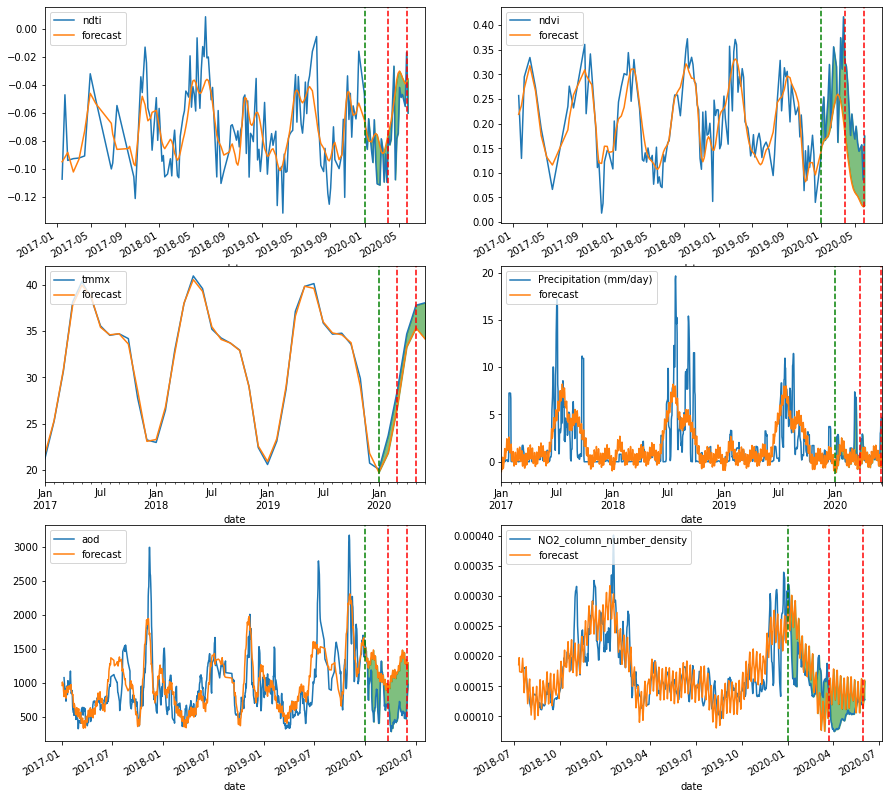

In [65]:
fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(15,15))
axs = axs.flatten()
rmses = []
mean_reductions_lockdowns = []
control_values = []
metrics = []
for counter, metric in enumerate(df.drop(['retail_and_recreation_percent_change_from_baseline','avg_rad'],axis=1).columns):
    if metric in ['tmmx','ndvi','ndti']:
      roll = 1
    else:
      roll = 7

    m,p,f = predict_var(metric,yearly_seasonal=True,roll=roll)
    test = f['2020-01':'2020-03-23']
    actual = test[metric].to_list()
    predicted = test.forecast.to_list()

    rmses.append(rmse_metric(actual, predicted))
    metrics.append(metric)

    f.plot(ax=axs[counter])
    axs[counter].axvline(x='2020-01-01',color='g',linestyle='--')
    axs[counter].axvline(x='2020-03-24',color='r',linestyle='--')
    axs[counter].axvline(x='2020-05-31',color='r',linestyle='--')
    axs[counter].legend(loc='upper left')
    axs[counter].fill_between(f['2020':].index, f[metric]['2020':],f['forecast']['2020':],color='green',alpha=0.5)
    
    f['diff'] = f['forecast']-f[metric]
    mean_reductions_lockdowns.append(f['2020-03-24':'2020-05-31']['diff'].mean())
    control_values.append(f['2020-03-24':'2020-05-31']['forecast'].mean()) 
plt.show()

In [61]:
impact = pd.DataFrame([metrics,control_values,mean_reductions_lockdowns]).T
impact.columns = ['metric','control_values_mean','mean_reduction']
impact['pct']=100*impact['mean_reduction']/impact['control_values_mean']
impact

,metric,control_values_mean,mean_reduction,pct
0,ndti,-0.047947,0.013209,-27.548476
1,ndvi,0.08482,-0.116715,-137.602407
2,tmmx,34.271664,-1.955064,-5.704607
3,Precipitation (mm/day),0.411339,-0.480926,-116.917226
4,aod,1145.391626,642.35582,56.081763
5,NO2_column_number_density,0.000134,0.000032,23.776867


In [62]:
# with avg_rad as regressor
rmses

[0.017700718405311767,
 0.0985291190805104,
 1.5243856189838025,
 2.0517021751019504,
 397.3235858536812,
 7.000280889351875e-05]

In [66]:
#no avg_rad as regressor
rmses

[0.018401908889222853,
 0.09929557570389831,
 1.4940755275162205,
 2.1569440368984125,
 443.18605655495213,
 5.767702027328682e-05]

In [ ]:
import statsmodels.formula.api as sm
lists = []
metrics = []
for counter, metric in enumerate(df.drop(['retail_and_recreation_percent_change_from_baseline','avg_rad','Precipitation (mm/day)'],axis=1).columns):
  m,p,f = predict_var(metric,yearly_seasonal=True,roll=1)
  metrics.append(metric)
  did_t = f[[metric]][:'2020-05'].reset_index()
  did_t['treat'] = 1
  did_t.columns=['date',metric,'treat']
  
  did_c = f[['forecast']][:'2020-05'].reset_index()
  did_c['treat'] = 0
  did_c.columns=['date',metric,'treat']

  did = pd.concat([did_t,did_c])
  did.loc[did['date']>='2020-03-24', 'after'] = 1

  est = sm.ols(data=did.fillna(0),
             formula = '{} ~ treat + after + treat*after'.format(metric))
  
  did_beta = pd.read_html(est.fit().summary().tables[1].as_html(),header=0,index_col=0)[0]
  lists.append(did_beta.loc['treat:after'].to_list())

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
did_beta = pd.DataFrame(lists).T
did_beta.index = ['coef', 'std err', 't', 'p','CEL','CEU']
did_beta.columns = metrics
did_beta = did_beta.T

In [ ]:
did_beta.loc[did_beta.p < 0.01, 'coef'] = did_beta.coef.astype(str) + str('***')
did_beta.loc[(did_beta.p < 0.05)&(did_beta.p >= 0.01), 'coef'] = did_beta.coef.astype(str) + str('**')
did_beta.loc[(did_beta.p < 0.1)&(did_beta.p >= 0.05), 'coef'] = did_beta.coef.astype(str) + str('*')
did_beta

,coef,std err,t,p,CEL,CEU
ndti,-0.0012,0.011000,-0.111,0.912,-0.023000,0.020000
ndvi,0.0385,0.033000,1.171,0.243,-0.026000,0.103000
tmmx,-3.1707,6.455000,-0.491,0.625,-16.023000,9.681000
aod,-554.0984***,97.024000,-5.711,0.000,-744.381000,-363.816000
NO2_column_number_density,-3.908e-05***,0.000013,-3.038,0.002,-0.000064,-0.000014


In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [ ]:
df_cv = cross_validation(m,initial='366 days',horizon='59 days')
df_cv.tail()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-08-06 12:00:00 and 2020-01-01 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
339,2020-02-25,0.000160,0.000005,0.000324,0.000139,2020-01-01
340,2020-02-26,0.000171,-0.000001,0.000333,0.000151,2020-01-01
341,2020-02-27,0.000178,0.000018,0.000336,0.000288,2020-01-01
342,2020-02-28,0.000148,-0.000009,0.000297,0.000140,2020-01-01
343,2020-02-29,0.000133,-0.000030,0.000287,0.000163,2020-01-01


In [ ]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,6 days 00:00:00,5.412036e-09,0.000074,0.000055,0.325573,0.313936,0.970588
1,6 days 12:00:00,5.227424e-09,0.000072,0.000053,0.314145,0.313936,0.970588
2,7 days 00:00:00,5.576857e-09,0.000075,0.000056,0.331503,0.315335,0.970588
3,7 days 12:00:00,5.433772e-09,0.000074,0.000056,0.337065,0.321516,0.970588
4,8 days 00:00:00,5.666097e-09,0.000075,0.000057,0.355344,0.321516,0.950980
...,...,...,...,...,...,...,...
102,57 days 00:00:00,8.892127e-09,0.000094,0.000075,0.502833,0.313760,0.882353
103,57 days 12:00:00,8.905063e-09,0.000094,0.000076,0.501303,0.374065,0.882353
104,58 days 00:00:00,8.620365e-09,0.000093,0.000073,0.471119,0.245355,0.882353
105,58 days 12:00:00,8.866679e-09,0.000094,0.000075,0.487178,0.324659,0.852941


/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


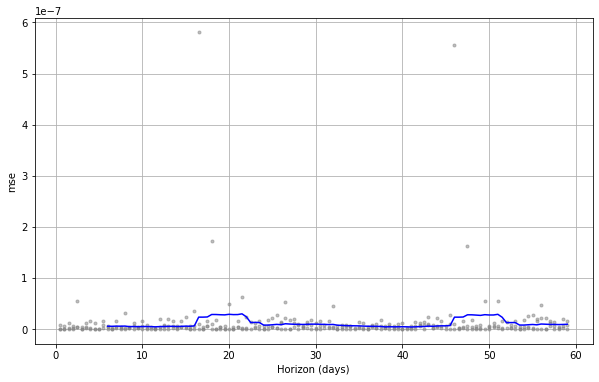

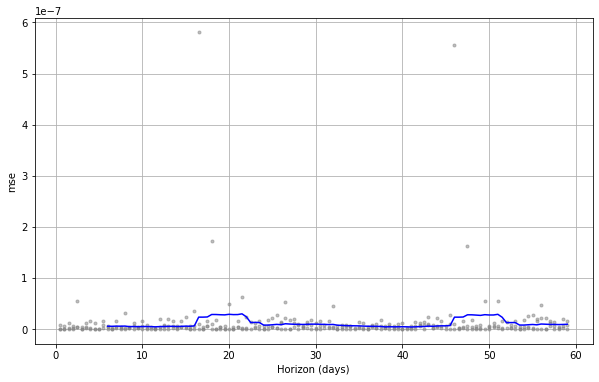

In [ ]:
plot_cross_validation_metric(df_cv,metric='mse')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


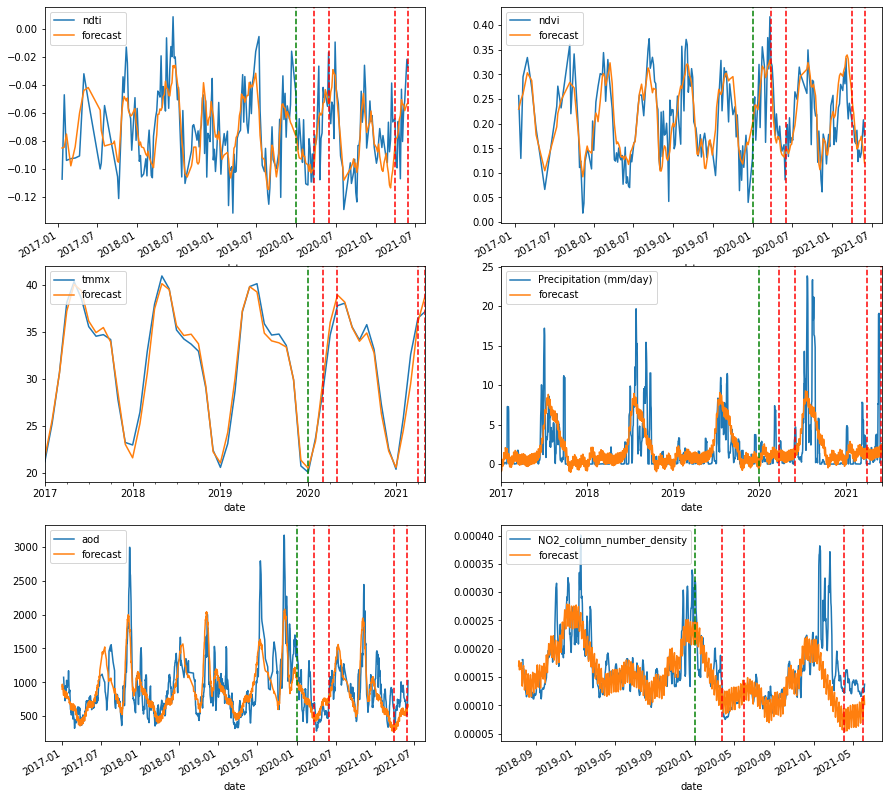

In [ ]:
fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(15,15))
axs = axs.flatten()
rmses = []
mean_reductions_lockdowns = []
control_values = []
metrics = []
for counter, metric in enumerate(df.drop(['retail_and_recreation_percent_change_from_baseline','avg_rad'],axis=1).columns):
    if metric in ['tmmx','ndvi','ndti']:
      roll = 1
    else:
      roll = 7

    m,p,f = predict_var(metric,yearly_seasonal=True,roll=roll,train_until='2020')
    test = f['2020-01':'2020-03-23']
    actual = test[metric].to_list()
    predicted = test.forecast.to_list()

    rmses.append(rmse_metric(actual, predicted))
    metrics.append(metric)

    f.plot(ax=axs[counter])
    axs[counter].axvline(x='2020-01-01',color='g',linestyle='--')
    axs[counter].axvline(x='2020-03-24',color='r',linestyle='--')
    axs[counter].axvline(x='2020-05-31',color='r',linestyle='--')
    axs[counter].axvline(x='2021-04-01',color='r',linestyle='--')
    axs[counter].axvline(x='2021-05-31',color='r',linestyle='--')
    axs[counter].legend(loc='upper left')
    #axs[counter].fill_between(f['2020':].index, f[metric]['2020':],f['forecast']['2020':],color='green',alpha=0.5)
    
    #f['diff'] = f['forecast']-f[metric]
    #mean_reductions_lockdowns.append(f['2020-03-24':'2020-05-31']['diff'].mean())
    #control_values.append(f['2020-03-24':'2020-05-31']['forecast'].mean()) 
plt.show()